In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
path = 'fastface_filtered-20220501-132848'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.7.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,[]


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-05-01 13:28:48.225005,8.9,3810033664
1,2022-05-01 13:29:00.079007,65.8,3597783040
2,2022-05-01 13:29:11.771004,69.9,3593551872
3,2022-05-01 13:29:23.366504,62.8,3597459456
4,2022-05-01 13:29:35.117506,67.2,3609485312
...,...,...,...
305,2022-05-01 14:28:31.560504,66.8,6965727232
306,2022-05-01 14:28:43.078505,65.6,7293931520
307,2022-05-01 14:28:54.145004,63.5,7270535168
308,2022-05-01 14:29:05.266006,61.8,7237926912


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

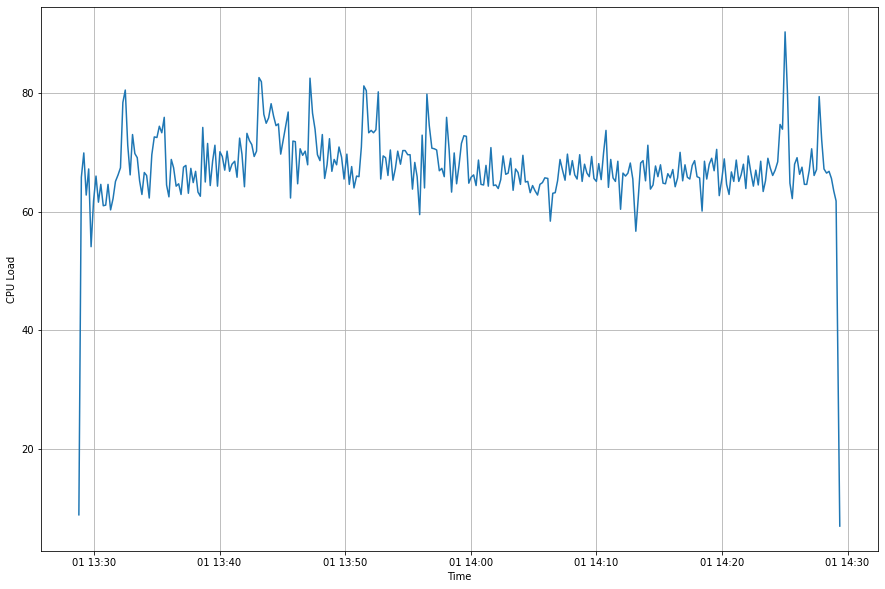

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

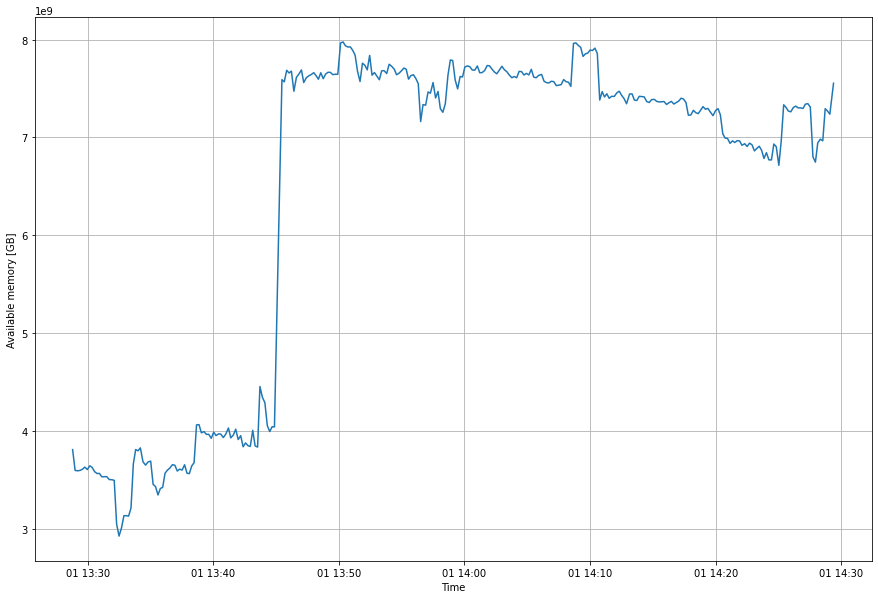

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

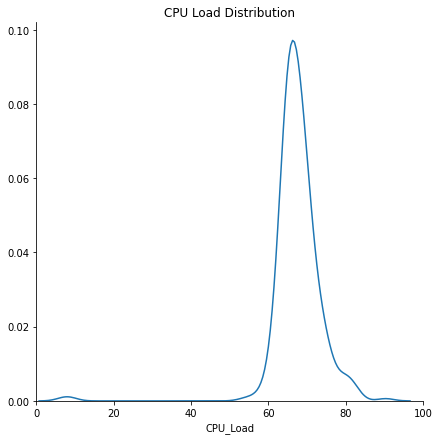

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

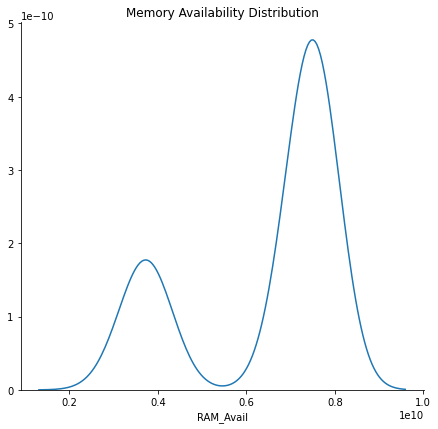

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-05-01 13:28:49.457003,1011176700,1.0,1.0,1.0,"[0.8154292343387471, 0.7578603511637403, 0.858...",8,0,0,8,"[(778.0, 190.0, 857.0, 289.0), (603.0, 323.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-05-01 13:28:51.740006,2277801700,0.0,0.0,0.0,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-05-01 13:28:52.595008,847070300,1.0,1.0,1.0,[0.7669295621430514],1,0,0,2,"[(460.0, 41.0, 500.0, 93.0), (555.0, 113.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-05-01 13:28:53.568503,862068200,0.0,0.0,0.0,[],0,0,0,62,"[(256.0, 496.0, 297.0, 546.0), (58.0, 494.0, 9...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-05-01 13:28:54.502506,914367600,1.0,1.0,1.0,"[0.9147646219686163, 0.8268525311812179, 0.902...",7,0,0,8,"[(272.0, 67.0, 317.0, 126.0), (789.0, 61.0, 83...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-05-01 14:29:08.107505,1897215500,0.0,0.0,0.0,[],0,0,1,1,[],"[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-05-01 14:29:10.002006,1886188600,0.0,0.0,0.0,[],0,0,2,2,[],"[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-05-01 14:29:10.932504,855021300,0.0,0.0,0.0,[],0,0,0,27,"[(583.0, 321.0, 609.0, 353.0), (842.0, 348.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-05-01 14:29:11.789006,840235100,1.0,1.0,1.0,"[0.6940459110473458, 0.7751824817518248]",2,0,0,7,"[(113.0, 110.0, 159.0, 165.0), (577.0, 67.0, 6...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,1.088541e+09,0.629419,0.623712,0.617242,1.741476,0.081525,0.467762,12.308741
std,6.480800e+08,0.467043,0.463514,0.456362,2.403898,0.324484,1.505252,39.822258
min,7.779903e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.651736e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.943487e+08,1.000000,1.000000,0.944272,1.000000,0.000000,0.000000,3.000000
75%,9.689395e+08,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,9.000000
max,2.934456e+10,1.000000,1.000000,1.000000,22.000000,4.000000,34.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,1.000000,True,True,True
1,1.000000,True,True,True
2,1.000000,True,True,True
3,1.000000,True,True,True
4,1.000000,True,True,True
...,...,...,...,...
5876,0.801276,False,False,False
5877,0.800768,True,True,False
5878,0.800169,False,False,False
5879,0.800084,False,False,False


In [13]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [14]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,1.000000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,1.000000,True,True,True,1.000000,0.000421,1.000000,0.000421,1.000000,0.000421
3,1.000000,True,True,True,1.000000,0.000561,1.000000,0.000561,1.000000,0.000561
4,1.000000,True,True,True,1.000000,0.000702,1.000000,0.000702,1.000000,0.000702
...,...,...,...,...,...,...,...,...,...,...
5876,0.801276,False,False,False,0.956100,0.788410,0.940786,0.775782,0.703590,0.580188
5877,0.800768,True,True,False,0.956108,0.788551,0.940796,0.775923,0.703471,0.580188
5878,0.800169,False,False,False,0.955945,0.788551,0.940636,0.775923,0.703351,0.580188
5879,0.800084,False,False,False,0.955782,0.788551,0.940476,0.775923,0.703231,0.580188


In [15]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

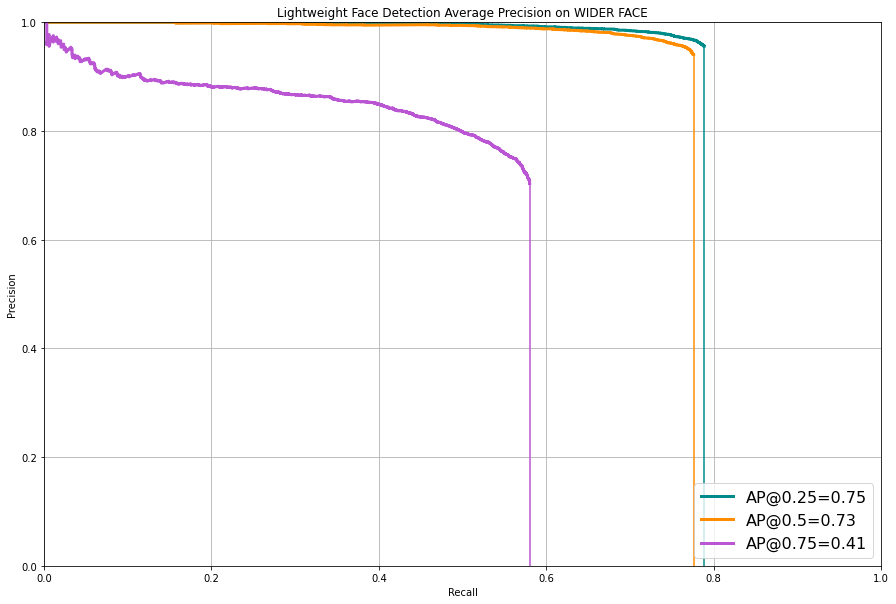

In [16]:
plot_pr(df_ap, 'Lightweight Face Detection Average Precision on filtered WIDER FACE')